## Testing function for whitening code.
### Note that this must be run from the root repository directory.

In [1]:
%matplotlib inline

In [4]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

root_path = os.path.dirname(os.path.dirname(os.getcwd()))
if root_path not in sys.path: sys.path.append(root_path)

import DeepSparseCoding.tf1x.data.data_selector as ds
import DeepSparseCoding.tf1x.utils.plot_functions as pf
import DeepSparseCoding.tf1x.utils.data_processing as dp

In [8]:
class data_params():
  def __init__(self):
    self.data_type = "vanHateren"
    self.num_images = 2
    self.extract_patches = False
    self.patch_edge_size = 8
    self.overlapping_patches = False
    self.randomize_patches = False
    self.image_edge_size = 256
    self.patch_variance_threshold = 0
    self.norm_data = False
    self.whiten_data = False
    self.contrast_normalize = False
    self.data_dir = os.path.expanduser("~")+"/Work/Datasets/"
    self.rand_seed = 5
params = data_params()

In [9]:
data = ds.get_data(params)

In [11]:
full_img = dp.reshape_data(data["train"].images, flatten=False)[0]
patches_per_image = int((512/params.patch_edge_size)**2)
patch_shape = (int(params.num_images*patches_per_image), int(params.patch_edge_size),
  int(params.patch_edge_size), 1)
img_patches = dp.extract_patches(full_img, patch_shape, overlapping=params.overlapping_patches, 
  randomize=params.randomize_patches, var_thresh=params.patch_variance_threshold)
recon_full_img = dp.patches_to_image(img_patches, full_img.shape)

In [12]:
test_img = full_img[0,...]
test_patches = dp.extract_patches_from_single_image(test_img,
  [params.patch_edge_size, params.patch_edge_size, 1])
recon_test_img = dp.patches_to_image(test_patches, test_img.shape)
assert np.max(np.abs(test_img - recon_test_img)) == 0.0

In [13]:
ft_wht_data, ft_data_mean, ft_filter = dp.whiten_data(full_img, method="FT")
ft_unwht_data = dp.unwhiten_data(ft_wht_data, ft_data_mean, ft_filter, method="FT")

pca_wht_patches, pca_data_mean, pca_filter = dp.whiten_data(img_patches, method="PCA")
pca_wht_data = dp.patches_to_image(pca_wht_patches, im_shape=full_img.shape)
pca_unwht_patches = dp.unwhiten_data(pca_wht_patches, pca_data_mean, pca_filter, method="PCA")
pca_unwht_data = dp.patches_to_image(pca_unwht_patches, im_shape=full_img.shape)

zca_wht_patches, zca_data_mean, zca_filter = dp.whiten_data(img_patches, method="ZCA")
zca_wht_data = dp.patches_to_image(zca_wht_patches, im_shape=full_img.shape)
zca_unwht_patches = dp.unwhiten_data(zca_wht_patches, pca_data_mean, zca_filter, method="ZCA")
zca_unwht_data = dp.patches_to_image(zca_unwht_patches, im_shape=full_img.shape)

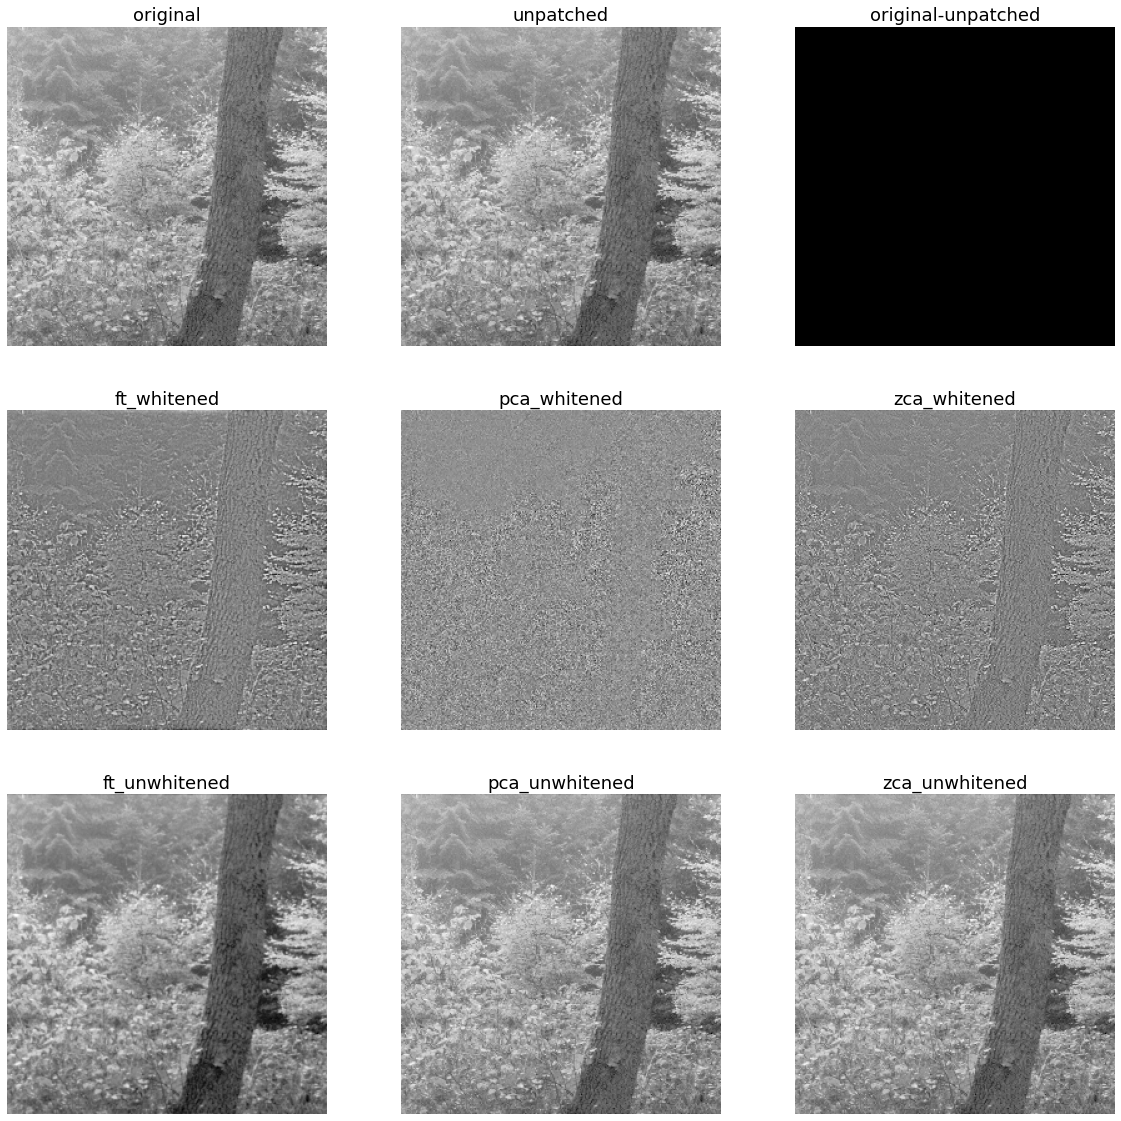

In [15]:
data_set = [full_img, recon_full_img, full_img-recon_full_img, ft_wht_data, pca_wht_data, zca_wht_data,
  ft_unwht_data, pca_unwht_data, zca_unwht_data]

data_keys = ["original", "unpatched", "original-unpatched", "ft_whitened", "pca_whitened", "zca_whitened",
  "ft_unwhitened", "pca_unwhitened", "zca_unwhitened"]
img_idx = np.random.choice(params.num_images, 1)[0]
num_plots_y = 3
num_plots_x = 3
fig, ax = plt.subplots(num_plots_y, num_plots_x, figsize=(20, 20))
img_count = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
  ax[plot_id] = pf.clear_axis(ax[plot_id])
  if img_count < len(data_set):
    ax[plot_id].imshow(np.squeeze(data_set[img_count][img_idx,...]), cmap="Greys_r")
    ax[plot_id].set_title(data_keys[img_count], fontsize=18)
  img_count += 1
plt.show()

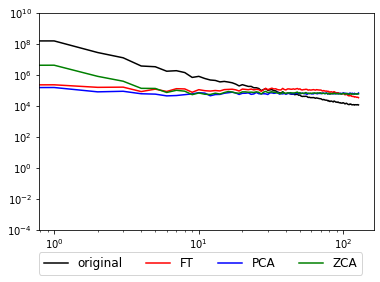

In [16]:
pspec = dp.phase_avg_pow_spec(full_img)
avg_pspec = np.mean(pspec, axis=0)

ft_pspec = dp.phase_avg_pow_spec(ft_wht_data)
avg_ft_pspec = np.mean(ft_pspec, axis=0)

pca_pspec = dp.phase_avg_pow_spec(pca_wht_data)
avg_pca_pspec = np.mean(pca_pspec, axis=0)

zca_pspec = dp.phase_avg_pow_spec(zca_wht_data)
avg_zca_pspec = np.mean(zca_pspec, axis=0)

(fig, ax) = plt.subplots(1)
ax.loglog(range(avg_pspec.shape[0]), avg_pspec, 'k', label="original")
ax.loglog(range(avg_ft_pspec.shape[0]), avg_ft_pspec, 'r', label="FT")
ax.loglog(range(avg_pca_pspec.shape[0]), avg_pca_pspec, 'b', label="PCA")
ax.loglog(range(avg_zca_pspec.shape[0]), avg_zca_pspec, 'g', label="ZCA")
ax.set_ylim([10**-4, 10**10])
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=12, ncol=4,
  borderaxespad=0., bbox_to_anchor=[0, -0.1], fancybox=True, loc="upper left")
plt.show()